#Idea
needed:
1. input spikes
  --> Randman from Zenke's tools
  --> to spike timing matri
2. SNN
    a. dynamics
    b. forward
    c. backward
    d. readout?
3. target sequences


1. create spiking dataset using Zenke's tools
2. Convert spike timing array to one-hot matrix
    'int(3)' to [0,0,0,1,0, ... , T]
3. convert labels to target one hot vectors (convolved)?
    One output neuron for

In [1]:
import numpy as np
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
import snn_utils
from randman.randman import *
import matplotlib.pyplot as plt
import seaborn as sns
from randman_utils import *


In [2]:
from LIFlayer import *

In [3]:
#reproducibility
import random
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Create Data

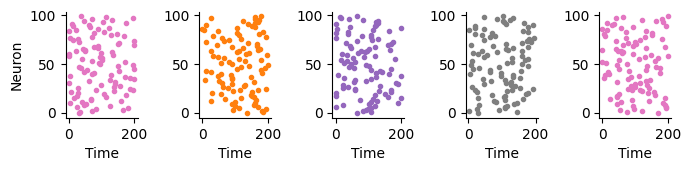

In [4]:
#Create spiking data set

N=100
T=200
batch_size=100
nb_classes = 10
data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=100,shuffle=True,alpha=1.5)
show_samples(data,labels)
data = torch.IntTensor(data)

In [5]:
def create_data(N,T,batch_size,nb_classes,nb_samples,alpha):
    data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=nb_samples,shuffle=True,alpha=alpha)
    show_samples(data,labels)
    data = torch.IntTensor(data)
    X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
    train_batch_ids = get_batches(X_train,batch_size)
    test_batch_ids = get_batches(X_test,batch_size)
    y_train = y_train.long()
    y_test = y_test.long()
    return X_train,X_test,y_train,y_test,train_batch_ids,test_batch_ids


In [6]:
def train_test(data,test_frac=.2):
    train = data[:int(len(data)*(1-test_frac))]
    test = data[int(len(data)*(1-test_frac)):]
    return train,test


In [7]:
def get_X_y(data,labels,T):
    X_train, X_test = train_test(data)
    y_train, y_test = train_test(labels)
    X_train = prep_data(X_train,T=T)
    X_test = prep_data(X_test, T=T)
    y_train = prep_labels(y_train)
    y_test = prep_labels(y_test)
    return X_train, X_test, y_train,y_test

X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
train_batch_ids = get_batches(X_train,batch_size)
test_batch_ids = get_batches(X_test,batch_size)

created 8 batches
created 2 batches


## Get mask

In [8]:

y_train = y_train.long()
y_test = y_test.long()

In [9]:
X_train.shape

torch.Size([800, 200, 100])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler

In [12]:
N = N
n_assemblies = nb_classes
epsilon =.5
base_w = 1
w_scale = [10]
w = 1
ss = StandardScaler()
mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
mask = (mask* (base_w*w)) + base_w

W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
if w > 0.:
    W *= base_w
    W *= mask
W2 = (W != 0).astype(int)

In [13]:
def get_Ws(N,nb_classes,epsilon=.5,base_w = 1,w = 1,plot=True):
    n_assemblies = nb_classes
    ss = StandardScaler()
    mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
    mask = (mask* (base_w*w)) + base_w

    W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
    if w > 0.:
        W *= base_w
        W *= mask

    if epsilon ==1:
        W = W-1
    W2 = (W != 0).astype(int)
    if plot:
        plt.title('W')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
        plt.title('W2')
        plt.imshow(W2)
        plt.colorbar()
        plt.show()
    return W,W2

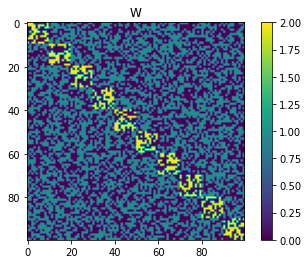

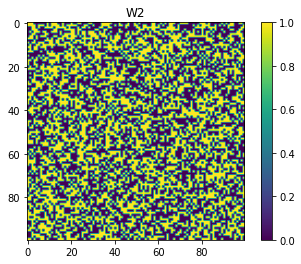

In [14]:
W,W2 = get_Ws(N,nb_classes=nb_classes)

In [16]:

W2

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0]])

### Helpers

In [15]:
import torch.nn as nn
from collections import namedtuple
from torch.nn import functional as F
NeuronState = namedtuple('NeuronState', ['U', 'I', 'S'])

from LIFlayer import LIFDensePopulation

def validation_acc(X_test,y_test,model,test_batch_ids):
    sum_acc = 0
    decay=.9
    count = 0
    for i in range(len(test_batch_ids)):
        model.eval()
        model.init_states()

        out = torch.zeros((batch_size,model.out_channels))
        out_rec = [out]
        count +=1
        for n in range(T):

            out_state = model(X_test[test_batch_ids[i],n])
            out_rec.append(out_state.U)


        out_rec = torch.stack(out_rec,dim=1)
        prediction = torch.max(out_rec,1).values

        accuracy = val_accuracy(prediction,y_test[test_batch_ids[i]])
        sum_acc = sum_acc + accuracy
    avg_acc = sum_acc/count
    if e%10 == 0:
        print(f'validation accuracy:{avg_acc}')
    return avg_acc,prediction,y_test[test_batch_ids[i]]

def val_accuracy(prediction,y):

    return (y == prediction.argmax(axis=1)).sum()/len(prediction)


In [15]:
(torch.Tensor([[3,4,5,6],[3,4,5,4]]).argmax(axis=1) == torch.Tensor([3,3])).sum()

tensor(1)

In [16]:
W = W-1

# One hidden layer

In [16]:
import scipy
device = 'cpu'
in_channels=N
hidden_channels = N
out_channels = nb_classes
model = OneHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,device='cpu', W=None)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
#model.init_mod_weights(W)
weights_before = model.layer1.fc_layer.weight

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))

params = model.parameters()
opt = torch.optim.Adam(params, lr=1e-4, betas=[0., .95]) #lr is the learning rate
#decay = .9
loss_hist = []
acc_hist = []
val_acc_hist = []
#epochs
for e in range(100):
    sum_loss = 0
    model.train()
    sum_acc=0
    #batches
    for i in range(len(train_batch_ids)):
        model.init_states()

        #Sprobe = torch.zeros((batch_size,model.out_channels))
        out = torch.zeros((batch_size,model.out_channels))
        out_rec = [out]
        #timesteps
        for n in range(T):
            out_state = model(X_train[train_batch_ids[i],n])

            #add decay for leakiness
            #collect spikes over time
            out_rec.append(out_state.U)


        out_rec = torch.stack(out_rec,dim=1)
        prediction = torch.max(out_rec,1).values

        #if i==0:
        #    print(prediction)

        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])

        #class labels only
        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        #tonic & torch neuromorphic

        loss.backward()
        opt.step()
        opt.zero_grad()
        #model.init_mod_weights(W2)
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist = loss_hist + [float(avg_loss)]
    acc_hist = acc_hist + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    #val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
    #val_acc_hist = val_acc_hist + [val_acc]
    #print(f'val_acc: {val_acc}')




epoch 0: 
 loss: 12.133018493652344
train_acc: 0.12125000357627869
epoch 1: 
 loss: 10.45991325378418
train_acc: 0.11999999731779099
epoch 2: 
 loss: 9.32093334197998
train_acc: 0.1274999976158142
epoch 3: 
 loss: 8.555333137512207
train_acc: 0.13375000655651093


KeyboardInterrupt: 

In [44]:
out_rec.shape

torch.Size([100, 101, 4])

In [22]:
y_train[train_batch_ids[i]]

tensor([0, 2, 3, 2, 1, 1, 1, 3, 3, 2, 1, 1, 0, 3, 3, 0, 0, 0, 3, 1, 0, 0, 0, 2,
        1, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 1, 2, 3, 0, 1, 2, 0, 1, 1, 1, 3, 3, 3,
        3, 1, 0, 1, 1, 3, 1, 1, 2, 1, 0, 3, 0, 2, 1, 3, 3, 3, 2, 3, 1, 3, 1, 3,
        2, 2, 1, 1, 1, 3, 3, 0, 0, 1, 0, 2, 3, 2, 1, 0, 1, 2, 3, 1, 2, 3, 0, 3,
        1, 1, 0, 0])

In [94]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
val_acc_hist = val_acc_hist + [val_acc]
print(f'val_acc: {val_acc}')

ZeroDivisionError: division by zero

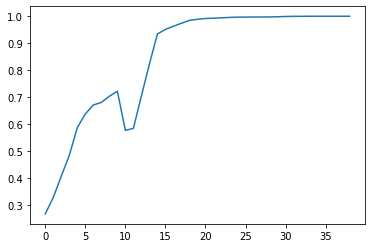

In [25]:
plt.plot(acc_hist)

In [61]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
val_acc

tensor(0.5550)

tensor(0.9937)

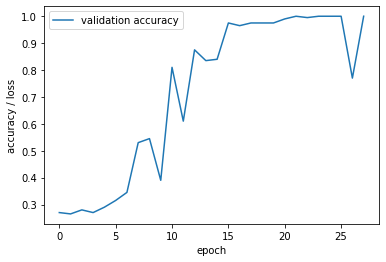

In [134]:
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy / loss')
plt.legend({'validation accuracy':'blue'})
#plt.savefig('snn_training.svg')

### Get data for smaller model

created 128 batches
created 32 batches


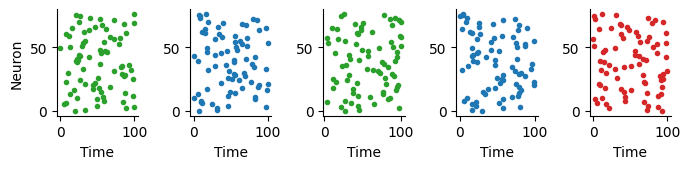

In [23]:
N= int(np.sqrt(W.sum()))
T=100
batch_size=25
nb_classes = 4
data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=1000,shuffle=True)
show_samples(data,labels)
data = torch.IntTensor(data)
X_train,X_test,y_train,y_test = get_X_y(data,labels,T)
train_batch_ids = get_batches(X_train,batch_size)
test_batch_ids = get_batches(X_test,batch_size)

In [72]:
fully_connected_in = int(np.sqrt(W.sum()))
in_channels= fully_connected_in
hidden_channels = fully_connected_in
out_channels = nb_classes
model2 = OneHiddenModel(fully_connected_in,fully_connected_in,out_channels,batch_size=batch_size)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
#model.init_mod_weights()

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))

params = model2.parameters()
opt = torch.optim.Adam(params, lr=1e-4, betas=[0., .95]) #lr is the learning rate

loss_hist_2 = []
acc_hist_2 = []
val_acc_hist_2 = []
#epochs
for e in range(100):
    sum_loss = 0
    model2.train()
    sum_acc=0
    #batches
    for i in range(len(train_batch_ids)):
        model2.init_states()

        Sprobe = torch.zeros((batch_size,model2.out_channels))

        #timesteps
        for n in range(T):
            out_state = model2(X_train[train_batch_ids[i],n])

            #collect spikes over time
            Sprobe = Sprobe + out_state.S



        prediction = Sprobe

        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])


        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        loss.backward()
        opt.step()
        opt.zero_grad()
        #model.init_mod_weights()
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist_2 = loss_hist_2 + [float(avg_loss)]
    acc_hist_2 = acc_hist_2 + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    val_acc,_,_ = validation_acc(X_test,y_test,model2,test_batch_ids)
    val_acc_hist_2 = val_acc_hist_2 + [val_acc]
    print(f'val_acc: {val_acc}')


epoch 0: 
 loss: 42.73112487792969
train_acc: 0.28333333134651184
validation accuracy:0.2933333218097687
val_acc: 0.2933333218097687
epoch 1: 
 loss: 32.20724105834961
train_acc: 0.29999998211860657
val_acc: 0.3866666555404663
epoch 2: 
 loss: 23.532617568969727
train_acc: 0.30666667222976685
val_acc: 0.35999998450279236
epoch 3: 
 loss: 19.588024139404297
train_acc: 0.2933333218097687
val_acc: 0.37333330512046814
epoch 4: 
 loss: 17.795679092407227
train_acc: 0.2600000202655792
val_acc: 0.3733333349227905
epoch 5: 
 loss: 15.734724998474121
train_acc: 0.273333340883255
val_acc: 0.37333330512046814
epoch 6: 
 loss: 13.115134239196777
train_acc: 0.2866666615009308
val_acc: 0.37333330512046814
epoch 7: 
 loss: 11.858535766601562
train_acc: 0.27666664123535156
val_acc: 0.3866666853427887
epoch 8: 
 loss: 10.911602973937988
train_acc: 0.2933332920074463
val_acc: 0.35999998450279236
epoch 9: 
 loss: 10.300016403198242
train_acc: 0.3400000333786011
val_acc: 0.3999999761581421
epoch 10: 
 los

KeyboardInterrupt: 

Text(0, 0.5, 'accuracy / loss')

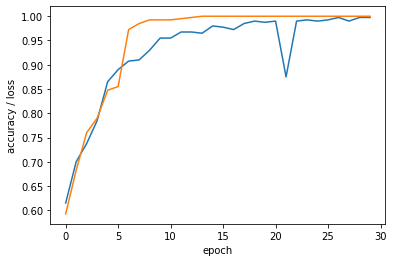

In [103]:
plt.plot(val_acc_hist)
#plt.plot(acc_hist)
plt.plot(val_acc_hist_2)
#plt.plot(acc_hist_2)
plt.xlabel('epoch')
plt.ylabel('accuracy / loss')

#plt.savefig('snn_training.svg')


created 32 batches
created 8 batches


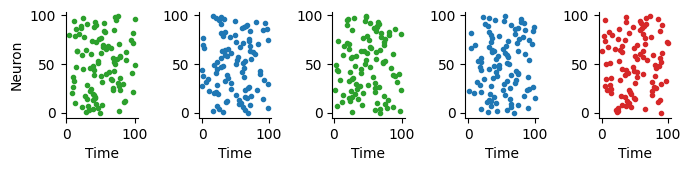

In [27]:
N=100
T=100
batch_size=100
nb_classes = 4
data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=1000,shuffle=True,alpha=1.5)
show_samples(data,labels)
data = torch.IntTensor(data)
X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
train_batch_ids = get_batches(X_train,batch_size)
test_batch_ids = get_batches(X_test,batch_size)

In [38]:
from LIFlayer import *
in_channels=N
hidden_channels = N
out_channels = nb_classes
model = ThreeHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
model.init_mod_weights()

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))

params = model.parameters()
opt = torch.optim.Adam(params, lr=1e-4, betas=[0., .95]) #lr is the learning rate

loss_hist = []
acc_hist = []
#epochs
for e in range(100):
    sum_loss = 0
    model.train()
    sum_acc=0
    #batches
    #if e%10 == 0:
    #    y = model.layer1.fc_layer.weight.clone().detach()
    #    plt.imshow(y)
    #    plt.show()

    for i in range(len(train_batch_ids)):
        model.init_states()

        Sprobe = torch.zeros((batch_size,model.out_channels))

        #timesteps
        for n in range(T):
            out_state = model(X_train[train_batch_ids[i],n])

            #collect spikes over time
            Sprobe = Sprobe + out_state.S
        prediction = Sprobe
        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])
        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        loss.backward()
        opt.step()
        opt.zero_grad()
        #model.init_mod_weights()
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist = loss_hist + [float(avg_loss)]
    acc_hist = acc_hist + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
    print(f'train_acc: {avg_train_acc}')
    val_acc_hist = acc_hist + [val_acc]
    print(f'val_acc: {val_acc}')


epoch 0: 
 loss: 25.646936416625977
train_acc: 0.26468750834465027
validation accuracy:0.29750001430511475
train_acc: 0.26468750834465027
val_acc: 0.29750001430511475
epoch 1: 
 loss: 3.194425106048584
train_acc: 0.28437501192092896
train_acc: 0.28437501192092896
val_acc: 0.28999999165534973
epoch 2: 
 loss: 1.6334151029586792
train_acc: 0.28125
train_acc: 0.28125
val_acc: 0.29749998450279236
epoch 3: 
 loss: 1.4471495151519775
train_acc: 0.29468750953674316
train_acc: 0.29468750953674316
val_acc: 0.3112500011920929
epoch 4: 
 loss: 1.4036775827407837
train_acc: 0.3121874928474426
train_acc: 0.3121874928474426
val_acc: 0.3174999952316284
epoch 5: 
 loss: 1.3608022928237915
train_acc: 0.32843756675720215
train_acc: 0.32843756675720215
val_acc: 0.3387499749660492
epoch 6: 
 loss: 1.3211994171142578
train_acc: 0.3459375202655792
train_acc: 0.3459375202655792
val_acc: 0.3487499952316284
epoch 7: 
 loss: 1.3055143356323242
train_acc: 0.3671874403953552
train_acc: 0.3671874403953552
val_acc:

KeyboardInterrupt: 

5000

In [201]:
N = N
n_assemblies = 5
epsilon =.5
base_w = 1
w_scale = [10]
w = 5
ss = StandardScaler()
mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
mask = (mask* (base_w*w)) + base_w

W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
if w > 0.:
    W *= base_w
    W *= mask

In [58]:
W = W-1

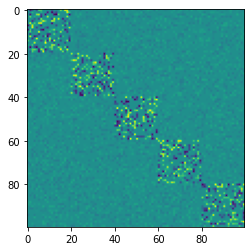

epoch 0: 
 loss: 19.377283096313477
train_acc: 0.2487500011920929
validation accuracy:0.23999997973442078
val_acc: 0.23999997973442078
epoch 1: 
 loss: 3.843165159225464
train_acc: 0.26374995708465576
val_acc: 0.3149999976158142
epoch 2: 
 loss: 1.6284267902374268
train_acc: 0.26624995470046997
val_acc: 0.32999998331069946
epoch 3: 
 loss: 1.5381460189819336
train_acc: 0.25499993562698364
val_acc: 0.32999998331069946
epoch 4: 
 loss: 1.4961018562316895
train_acc: 0.2750000059604645
val_acc: 0.3100000023841858
epoch 5: 
 loss: 1.412017583847046
train_acc: 0.273749977350235
val_acc: 0.23499998450279236
epoch 6: 
 loss: 1.3732349872589111
train_acc: 0.26124995946884155
val_acc: 0.23499998450279236
epoch 7: 
 loss: 1.3816897869110107
train_acc: 0.2512499690055847
val_acc: 0.23499998450279236
epoch 8: 
 loss: 1.4111950397491455
train_acc: 0.26750001311302185
val_acc: 0.23999997973442078
epoch 9: 
 loss: 1.4447308778762817
train_acc: 0.26874998211860657
val_acc: 0.23499998450279236


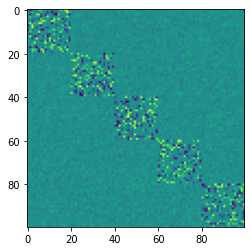

epoch 10: 
 loss: 1.3832900524139404
train_acc: 0.26499998569488525
validation accuracy:0.2549999952316284
val_acc: 0.2549999952316284
epoch 11: 
 loss: 1.4107699394226074
train_acc: 0.2800000011920929
val_acc: 0.2549999952316284
epoch 12: 
 loss: 1.3804636001586914
train_acc: 0.29124999046325684
val_acc: 0.2800000011920929
epoch 13: 
 loss: 1.4453949928283691
train_acc: 0.28999999165534973
val_acc: 0.36500000953674316
epoch 14: 
 loss: 1.3755958080291748
train_acc: 0.29249998927116394
val_acc: 0.2849999964237213
epoch 15: 
 loss: 1.3886526823043823
train_acc: 0.29624998569488525
val_acc: 0.32999998331069946
epoch 16: 
 loss: 1.4066637754440308
train_acc: 0.3037499785423279
val_acc: 0.30000001192092896
epoch 17: 
 loss: 1.3885211944580078
train_acc: 0.3137499690055847
val_acc: 0.30000001192092896
epoch 18: 
 loss: 1.349234938621521
train_acc: 0.336249977350235
val_acc: 0.29500001668930054
epoch 19: 
 loss: 1.370956301689148
train_acc: 0.30375000834465027
val_acc: 0.29500001668930054


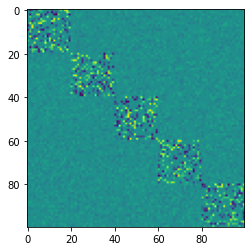

epoch 20: 
 loss: 1.375012993812561
train_acc: 0.32249996066093445
validation accuracy:0.2749999761581421
val_acc: 0.2749999761581421
epoch 21: 
 loss: 1.3665485382080078
train_acc: 0.3124999701976776
val_acc: 0.2750000059604645
epoch 22: 
 loss: 1.3766833543777466
train_acc: 0.29749998450279236
val_acc: 0.2750000059604645
epoch 23: 
 loss: 1.374584674835205
train_acc: 0.3162499666213989
val_acc: 0.2800000011920929
epoch 24: 
 loss: 1.3313599824905396
train_acc: 0.32499992847442627
val_acc: 0.2849999964237213
epoch 25: 
 loss: 1.337045669555664
train_acc: 0.34499993920326233
val_acc: 0.28999999165534973
epoch 26: 
 loss: 1.3368757963180542
train_acc: 0.34249988198280334
val_acc: 0.2800000011920929
epoch 27: 
 loss: 1.3474526405334473
train_acc: 0.3574999272823334
val_acc: 0.2849999964237213
epoch 28: 
 loss: 1.3073326349258423
train_acc: 0.35999995470046997
val_acc: 0.4350000023841858
epoch 29: 
 loss: 1.2838226556777954
train_acc: 0.3399999439716339
val_acc: 0.2800000011920929


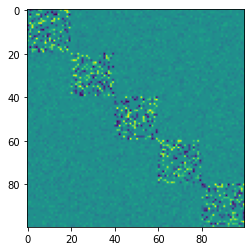

epoch 30: 
 loss: 1.2939385175704956
train_acc: 0.35624992847442627
validation accuracy:0.30000001192092896
val_acc: 0.30000001192092896
epoch 31: 
 loss: 1.3283237218856812
train_acc: 0.35124990344047546
val_acc: 0.2750000059604645
epoch 32: 
 loss: 1.2896411418914795
train_acc: 0.37624990940093994
val_acc: 0.28999999165534973
epoch 33: 
 loss: 1.326597809791565
train_acc: 0.34499990940093994
val_acc: 0.3050000071525574
epoch 34: 
 loss: 1.3129634857177734
train_acc: 0.3437499403953552
val_acc: 0.3100000023841858
epoch 35: 
 loss: 1.3024795055389404
train_acc: 0.3662499487400055
val_acc: 0.29499998688697815
epoch 36: 
 loss: 1.2969813346862793
train_acc: 0.35624992847442627
val_acc: 0.2849999964237213
epoch 37: 
 loss: 1.2803550958633423
train_acc: 0.3562498986721039
val_acc: 0.3699999749660492
epoch 38: 
 loss: 1.2985072135925293
train_acc: 0.3387499749660492
val_acc: 0.3149999976158142
epoch 39: 
 loss: 1.2608722448349
train_acc: 0.3887499272823334
val_acc: 0.29500001668930054


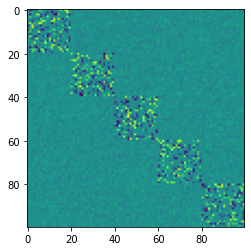

epoch 40: 
 loss: 1.2522549629211426
train_acc: 0.4199999272823334
validation accuracy:0.28999999165534973
val_acc: 0.28999999165534973
epoch 41: 
 loss: 1.2422114610671997
train_acc: 0.4224998950958252
val_acc: 0.32499995827674866
epoch 42: 
 loss: 1.248881220817566
train_acc: 0.3624999523162842
val_acc: 0.2849999964237213
epoch 43: 
 loss: 1.260434865951538
train_acc: 0.3987499177455902
val_acc: 0.4599999785423279
epoch 44: 
 loss: 1.2278313636779785
train_acc: 0.3949999511241913
val_acc: 0.3100000023841858
epoch 45: 
 loss: 1.2727916240692139
train_acc: 0.38374990224838257
val_acc: 0.31999996304512024
epoch 46: 
 loss: 1.2738611698150635
train_acc: 0.37624990940093994
val_acc: 0.32999998331069946
epoch 47: 
 loss: 1.2667211294174194
train_acc: 0.35499998927116394
val_acc: 0.3149999678134918
epoch 48: 
 loss: 1.2693370580673218
train_acc: 0.3699999153614044
val_acc: 0.29999998211860657
epoch 49: 
 loss: 1.2530567646026611
train_acc: 0.37874993681907654
val_acc: 0.3500000238418579


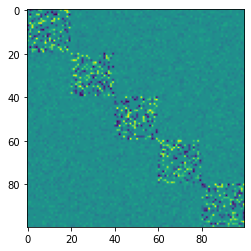

epoch 50: 
 loss: 1.2743101119995117
train_acc: 0.38374993205070496
validation accuracy:0.41499999165534973
val_acc: 0.41499999165534973
epoch 51: 
 loss: 1.2580149173736572
train_acc: 0.3924999237060547
val_acc: 0.48500001430511475
epoch 52: 
 loss: 1.2593350410461426
train_acc: 0.38374990224838257
val_acc: 0.3800000250339508
epoch 53: 
 loss: 1.2900805473327637
train_acc: 0.38499993085861206
val_acc: 0.320000022649765
epoch 54: 
 loss: 1.2024052143096924
train_acc: 0.4287499189376831
val_acc: 0.3400000035762787
epoch 55: 
 loss: 1.2322391271591187
train_acc: 0.4137498736381531
val_acc: 0.49000000953674316
epoch 56: 
 loss: 1.1894385814666748
train_acc: 0.4524998664855957
val_acc: 0.48500001430511475
epoch 57: 
 loss: 1.1751564741134644
train_acc: 0.43499991297721863
val_acc: 0.48500001430511475
epoch 58: 
 loss: 1.217318058013916
train_acc: 0.4274998903274536
val_acc: 0.48500001430511475
epoch 59: 
 loss: 1.1687852144241333
train_acc: 0.4487498998641968
val_acc: 0.4750000238418579


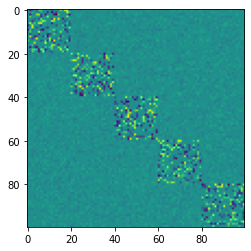

epoch 60: 
 loss: 1.163804292678833
train_acc: 0.4312499165534973
validation accuracy:0.48000001907348633
val_acc: 0.48000001907348633
epoch 61: 
 loss: 1.1732913255691528
train_acc: 0.4337499141693115
val_acc: 0.4700000286102295
epoch 62: 
 loss: 1.1907035112380981
train_acc: 0.43624985218048096
val_acc: 0.49000000953674316
epoch 63: 
 loss: 1.2257415056228638
train_acc: 0.4324999451637268
val_acc: 0.48500001430511475
epoch 64: 
 loss: 1.2288450002670288
train_acc: 0.41874992847442627
val_acc: 0.5149999856948853
epoch 65: 
 loss: 1.2025502920150757
train_acc: 0.4512499272823334
val_acc: 0.4899999797344208
epoch 66: 
 loss: 1.2004998922348022
train_acc: 0.43124985694885254
val_acc: 0.375
epoch 67: 
 loss: 1.169987440109253
train_acc: 0.4412499666213989
val_acc: 0.36000001430511475
epoch 68: 
 loss: 1.1511837244033813
train_acc: 0.4199999272823334
val_acc: 0.3700000047683716
epoch 69: 
 loss: 1.197662115097046
train_acc: 0.4337499141693115
val_acc: 0.36000001430511475


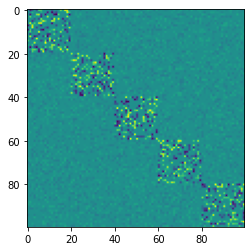

epoch 70: 
 loss: 1.1692373752593994
train_acc: 0.47624990344047546
validation accuracy:0.36500000953674316
val_acc: 0.36500000953674316
epoch 71: 
 loss: 1.196082353591919
train_acc: 0.44624996185302734
val_acc: 0.36000001430511475
epoch 72: 
 loss: 1.1567223072052002
train_acc: 0.4499998688697815
val_acc: 0.375
epoch 73: 
 loss: 1.1766949892044067
train_acc: 0.4599998891353607
val_acc: 0.38999998569488525
epoch 74: 
 loss: 1.0930290222167969
train_acc: 0.48124995827674866
val_acc: 0.39000001549720764
epoch 75: 
 loss: 1.1368588209152222
train_acc: 0.47249990701675415
val_acc: 0.5049999952316284
epoch 76: 
 loss: 1.1568669080734253
train_acc: 0.46374988555908203
val_acc: 0.5099999904632568
epoch 77: 
 loss: 1.1221415996551514
train_acc: 0.44999992847442627
val_acc: 0.4950000047683716
epoch 78: 
 loss: 1.1302889585494995
train_acc: 0.46249985694885254
val_acc: 0.39500001072883606
epoch 79: 
 loss: 1.1390482187271118
train_acc: 0.429999977350235
val_acc: 0.5049999952316284


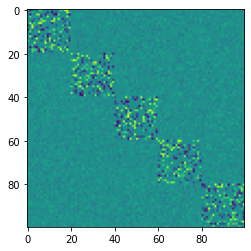

epoch 80: 
 loss: 1.0857356786727905
train_acc: 0.4862499237060547
validation accuracy:0.5049999952316284
val_acc: 0.5049999952316284
epoch 81: 
 loss: 1.1324243545532227
train_acc: 0.45124995708465576
val_acc: 0.39500001072883606
epoch 82: 
 loss: 1.1537535190582275
train_acc: 0.4574998617172241
val_acc: 0.4000000059604645
epoch 83: 
 loss: 1.126139521598816
train_acc: 0.4562499225139618
val_acc: 0.39500001072883606
epoch 84: 
 loss: 1.1340309381484985
train_acc: 0.4587499499320984
val_acc: 0.5149999856948853
epoch 85: 
 loss: 1.1378945112228394
train_acc: 0.4637499451637268
val_acc: 0.5149999856948853
epoch 86: 
 loss: 1.1160451173782349
train_acc: 0.5224998593330383
val_acc: 0.5249999761581421
epoch 87: 
 loss: 1.1347434520721436
train_acc: 0.5087499022483826
val_acc: 0.49000000953674316
epoch 88: 
 loss: 1.1590874195098877
train_acc: 0.489999920129776
val_acc: 0.49000000953674316
epoch 89: 
 loss: 1.124616265296936
train_acc: 0.4862498641014099
val_acc: 0.5449999570846558


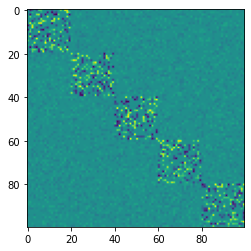

epoch 90: 
 loss: 1.1703447103500366
train_acc: 0.5024999380111694
validation accuracy:0.5049999952316284
val_acc: 0.5049999952316284
epoch 91: 
 loss: 1.1628497838974
train_acc: 0.48625001311302185
val_acc: 0.5299999713897705
epoch 92: 
 loss: 1.099247694015503
train_acc: 0.45374998450279236
val_acc: 0.5149999856948853
epoch 93: 
 loss: 1.0840692520141602
train_acc: 0.5024999380111694
val_acc: 0.42500001192092896
epoch 94: 
 loss: 1.1385384798049927
train_acc: 0.4899998605251312
val_acc: 0.5600000023841858
epoch 95: 
 loss: 1.0771762132644653
train_acc: 0.4887499511241913
val_acc: 0.5199999809265137
epoch 96: 
 loss: 1.089411735534668
train_acc: 0.49999991059303284
val_acc: 0.42000001668930054
epoch 97: 
 loss: 1.1226391792297363
train_acc: 0.4587499499320984
val_acc: 0.5399999618530273
epoch 98: 
 loss: 1.0803858041763306
train_acc: 0.48124995827674866
val_acc: 0.5300000309944153
epoch 99: 
 loss: 1.084608554840088
train_acc: 0.4862498939037323
val_acc: 0.44999998807907104


In [211]:


in_channels=N
hidden_channels = N
out_channels = nb_classes
model = ThreeHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
model.init_mod_weights()

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
params = model.parameters()
opt = torch.optim.Adam(params, lr=1.5e-4, betas=[0., .95]) #lr is the learning rate

loss_hist2 = []
acc_hist2 = []
val_acc_hist = []
#epochs
for e in range(100):
    sum_loss = 0
    model.train()
    sum_acc=0
    #batches

    if e%10 == 0:
        y = model.layer1.fc_layer.weight.clone().detach()
        plt.imshow(y)
        plt.show()
    #plt.imshow(W)
    #plt.show()
    for i in range(len(train_batch_ids)):
        model.init_states()

        Sprobe = torch.zeros((batch_size,model.out_channels))

        #timesteps
        for n in range(T):
            out_state = model(X_train[train_batch_ids[i],n])

            #collect spikes over time
            Sprobe = Sprobe + out_state.S



        prediction = Sprobe

        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])


        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        loss.backward()
        opt.step()
        opt.zero_grad()

        #model.init_mod_weights()
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist2 = loss_hist2 + [float(avg_loss)]
    acc_hist2 = acc_hist2 + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
    val_acc_hist += [val_acc]
    print(f'val_acc: {val_acc}')

In [193]:
W

array([[2., 0., 2., ..., 0., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 0., 2., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 2., 2., 2.],
       [0., 1., 1., ..., 0., 2., 0.],
       [1., 1., 1., ..., 2., 2., 2.]])

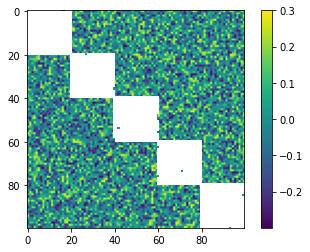

In [187]:
plt.imshow(model.layer1.fc_layer.weight.detach().numpy())
plt.colorbar()

In [188]:
model.layer1.fc_layer.weight.detach().numpy()

array([[       -inf,  0.        ,        -inf, ...,  0.        ,
         0.23490462,  0.13091323],
       [        inf,         inf,         inf, ...,  0.14563453,
        -0.12155899,  0.08310922],
       [       -inf, -0.        ,         inf, ..., -0.19035193,
        -0.00342843,  0.2965851 ],
       ...,
       [-0.22665054,  0.17989966,  0.14465132, ...,         inf,
                inf,        -inf],
       [-0.        , -0.10206229, -0.1533031 , ...,  0.        ,
                inf, -0.        ],
       [ 0.10463918,  0.01108154, -0.24829842, ...,         inf,
                inf,         inf]], dtype=float32)

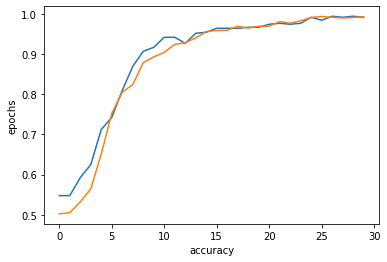

In [85]:
plt.plot(val_acc_hist)
plt.plot(acc_hist2)
plt.xlabel('accuracy')
plt.ylabel('epochs')
plt.show()

# Five hidden

In [17]:

in_channels=N
hidden_channels = N
out_channels = nb_classes
model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
model.init_mod_weights(W)

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))

params = model.parameters()
opt = torch.optim.Adam(params, lr=1e-4, betas=[0., .95]) #lr is the learning rate
decay = .9
loss_hist = []
acc_hist = []
val_acc_hist = []
#epochs
for e in range(1000):
    sum_loss = 0
    model.train()
    sum_acc=0
    #batches
    for i in range(len(train_batch_ids)):
        model.init_states()

        Sprobe = torch.zeros((batch_size,model.out_channels))

        #timesteps
        for n in range(T):
            out_state = model(X_train[train_batch_ids[i],n])

            #collect spikes over time
            Sprobe = decay * Sprobe + out_state.S

        prediction = Sprobe

        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])


        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        loss.backward()
        opt.step()
        opt.zero_grad()
        model.init_mod_weights(W2)
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist = loss_hist + [float(avg_loss)]
    acc_hist = acc_hist + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    #val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
    #val_acc_hist += [val_acc]
    #print(f'val_acc: {val_acc}')

epoch 0: 
 loss: 2.8368144035339355
train_acc: 0.2643750011920929
epoch 1: 
 loss: 2.096850872039795
train_acc: 0.2590624988079071
epoch 2: 
 loss: 1.7349070310592651
train_acc: 0.25968751311302185
epoch 3: 
 loss: 1.5733788013458252
train_acc: 0.2446875125169754
epoch 4: 
 loss: 1.4738013744354248
train_acc: 0.25562500953674316
epoch 5: 
 loss: 1.4218820333480835
train_acc: 0.258124977350235
epoch 6: 
 loss: 1.4012188911437988
train_acc: 0.25093749165534973
epoch 7: 
 loss: 1.3907042741775513
train_acc: 0.2537500262260437
epoch 8: 
 loss: 1.385811448097229
train_acc: 0.25468751788139343
epoch 9: 
 loss: 1.3829165697097778
train_acc: 0.257500022649765
epoch 10: 
 loss: 1.3794629573822021
train_acc: 0.26062503457069397
epoch 11: 
 loss: 1.3739694356918335
train_acc: 0.2606250047683716
epoch 12: 
 loss: 1.3764441013336182
train_acc: 0.2640624940395355
epoch 13: 
 loss: 1.3656262159347534
train_acc: 0.2703125476837158
epoch 14: 
 loss: 1.3723089694976807
train_acc: 0.2668750286102295
epoc

val_acc: 0.8787499666213989


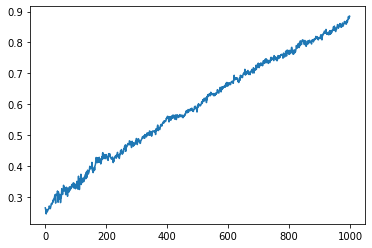

In [18]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
val_acc_hist += [val_acc]
print(f'val_acc: {val_acc}')
plt.plot(acc_hist)

val_acc: 0.9987499713897705


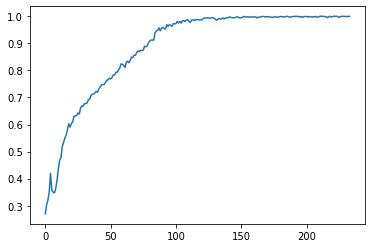

In [16]:
#not using W

val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
val_acc_hist += [val_acc]
print(f'val_acc: {val_acc}')
plt.plot(acc_hist)

In [17]:
from LIFlayer import FiveHiddenModel
def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay,epochs=100,use_W=False,use_W2=False,print_each=5):
    in_channels=N
    hidden_channels = N
    out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    #epochs
    for e in range(epochs):
        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        for i in range(len(train_batch_ids)):

            model.init_states()

            out = torch.zeros((batch_size,model.out_channels))
            out_rec = [out]
        #timesteps
            for n in range(T):
                out_state = model(X_train[train_batch_ids[i],n])

            #add decay for leakiness
            #collect spikes over time
                out_rec.append(out_state.U)

            out_rec = torch.stack(out_rec,dim=1)
            prediction = torch.max(out_rec,1).values
            accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])
            loss = ce_loss(prediction,y_train[train_batch_ids[i]])

            loss.backward()
            opt.step()
            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]


        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist
        #val_acc,_,_ = validation_acc(Xtest,y_test,model,test_batch_ids)
        #val_acc_hist += [val_acc]
      #print(f'val_acc: {val_acc}')

In [111]:
X_train.shape

torch.Size([320, 100, 100])

In [110]:
test_batch_ids

array([[12, 45, 50, 79, 18, 54, 74, 43, 46, 64, 60, 15, 75, 51, 32, 19,
        44, 42,  4, 14, 34, 49,  2, 31, 59, 38, 69, 77,  7, 10, 55, 66,
        53,  0,  1, 27, 48, 68, 56,  9],
       [ 6, 52, 67, 78, 47,  5, 30, 26, 62, 70, 61, 22, 11, 76, 71, 72,
        16, 33, 37, 40, 35, 41, 20, 63, 17, 36, 28, 57, 25,  3, 21, 24,
        65, 39,  8, 13, 58, 29, 73, 23]])

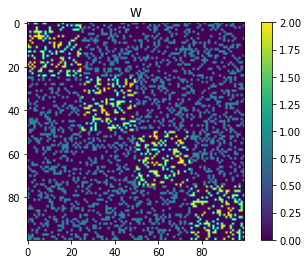

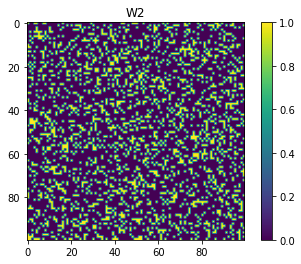

created 80 batches
created 20 batches


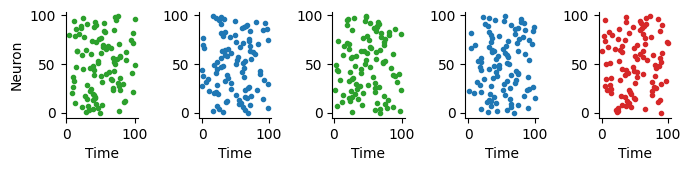

In [18]:
N=100
T=100
batch_size=40
nb_classes=4
W,W2 = get_Ws(N=N,nb_classes=nb_classes,epsilon=.25)

X_train,X_test,y_train, y_test, train_batch_ids,test_batch_ids =create_data(N=N,T=T,batch_size=batch_size,nb_classes=nb_classes,nb_samples=1000,alpha=1.5)
model = OneHiddenModel(in_channels=N,hidden_channels=N,out_channels=nb_classes,batch_size=batch_size)

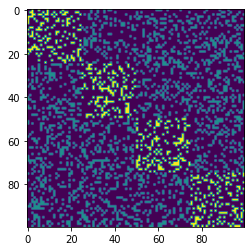

In [196]:
plt.imshow(W)

In [19]:
loss, acc = train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W=W,W2=W2,lr=1e-4,decay=.9,use_W=False,use_W2=False,print_each=5,epochs=10)

epoch 0: 
 loss: 3.345127820968628
train_acc: 0.2759375274181366
epoch 5: 
 loss: 1.1516801118850708
train_acc: 0.43562498688697815


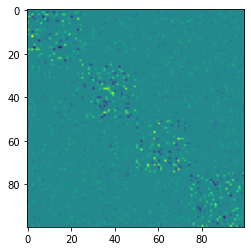

In [194]:
plt.imshow(model.layer1.fc_layer.weight.data)

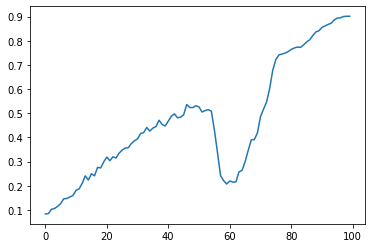

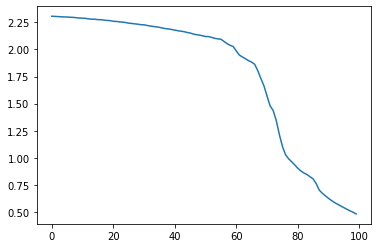

In [120]:
plt.plot(acc_hist)
plt.show()
plt.plot(loss_hist)

In [197]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
val_acc_hist += [val_acc]
print(f'val_acc: {val_acc}')

val_acc: 0.9837499856948853


In [21]:
fully_connected_in = int(np.sqrt(W.sum()))
in_channels= fully_connected_in
hidden_channels = fully_connected_in
out_channels = nb_classes
model2 = FiveHiddenModel(fully_connected_in,fully_connected_in,out_channels,batch_size=batch_size)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
#model.init_mod_weights()

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))

params = model2.parameters()
opt = torch.optim.Adam(params, lr=1.5e-4, betas=[0., .95]) #lr is the learning rate

loss_hist_2 = []
acc_hist_2 = []
val_acc_hist_2 = []
#epochs
for e in range(100):
    sum_loss = 0
    model2.train()
    sum_acc=0
    #batches
    for i in range(len(train_batch_ids)):
        model2.init_states()

        Sprobe = torch.zeros((batch_size,model2.out_channels))

        #timesteps
        for n in range(T):
            out_state = model2(X_train[train_batch_ids[i],n])

            #collect spikes over time
            Sprobe = Sprobe + out_state.S



        prediction = Sprobe

        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])


        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        loss.backward()
        opt.step()
        opt.zero_grad()
        #model.init_mod_weights()
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist_2 = loss_hist_2 + [float(avg_loss)]
    acc_hist_2 = acc_hist_2 + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    val_acc,_,_ = validation_acc(X_test,y_test,model2,test_batch_ids)
    val_acc_hist_2 = val_acc_hist_2 + [val_acc]
    print(f'val_acc: {val_acc}')

epoch 0: 
 loss: 30.57109832763672
train_acc: 0.23375000059604645
validation accuracy:0.3199999928474426
val_acc: 0.3199999928474426
epoch 1: 
 loss: 24.146207809448242
train_acc: 0.2474999725818634
val_acc: 0.29500001668930054
epoch 2: 
 loss: 3.2463674545288086
train_acc: 0.26125001907348633
val_acc: 0.2750000059604645
epoch 3: 
 loss: 1.6707444190979004
train_acc: 0.2537500262260437
val_acc: 0.2800000011920929
epoch 4: 
 loss: 1.5300239324569702
train_acc: 0.2499999850988388
val_acc: 0.24000000953674316
epoch 5: 
 loss: 1.4209517240524292
train_acc: 0.2412499487400055
val_acc: 0.22500000894069672
epoch 6: 
 loss: 1.5250906944274902
train_acc: 0.24749994277954102
val_acc: 0.2800000011920929
epoch 7: 
 loss: 1.4440522193908691
train_acc: 0.2874999940395355
val_acc: 0.2449999898672104
epoch 8: 
 loss: 1.472841501235962
train_acc: 0.2762499749660492
val_acc: 0.2499999850988388
epoch 9: 
 loss: 1.504252314567566
train_acc: 0.2712499797344208
val_acc: 0.28999999165534973
epoch 10: 
 loss:

In [22]:
fully_connected_in = int(np.sqrt(W.sum()))
in_channels= fully_connected_in
hidden_channels = fully_connected_in
out_channels = nb_classes
model2 = OneHiddenModel(fully_connected_in,fully_connected_in,out_channels,batch_size=batch_size)

#mse_loss = torch.nn.MSELoss()
ce_loss = torch.nn.CrossEntropyLoss()

#apply W
#model.init_mod_weights()

#layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))

params = model2.parameters()
opt = torch.optim.Adam(params, lr=1.5e-4, betas=[0., .95]) #lr is the learning rate

loss_hist_2 = []
acc_hist_2 = []
val_acc_hist_2 = []
#epochs
for e in range(100):
    sum_loss = 0
    model2.train()
    sum_acc=0
    #batches
    for i in range(len(train_batch_ids)):
        model2.init_states()

        Sprobe = torch.zeros((batch_size,model2.out_channels))

        #timesteps
        for n in range(T):
            out_state = model2(X_train[train_batch_ids[i],n])

            #collect spikes over time
            Sprobe = Sprobe + out_state.S



        prediction = Sprobe

        accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])


        loss = ce_loss(prediction,y_train[train_batch_ids[i]])

        loss.backward()
        opt.step()
        opt.zero_grad()
        #model.init_mod_weights()
        sum_acc = sum_acc + accuracy
        sum_loss = sum_loss + loss
    avg_train_acc = sum_acc/(len(train_batch_ids))
    avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:
    loss_hist_2 = loss_hist_2 + [float(avg_loss)]
    acc_hist_2 = acc_hist_2 + [float(avg_train_acc)]


    if e%1==0:
        print(f'epoch {e}: \n loss: {avg_loss}')
        print(f'train_acc: {avg_train_acc}')
    val_acc,_,_ = validation_acc(X_test,y_test,model2,test_batch_ids)
    val_acc_hist_2 = val_acc_hist_2 + [val_acc]
    print(f'val_acc: {val_acc}')

epoch 0: 
 loss: 15.501187324523926
train_acc: 0.2462499737739563
validation accuracy:0.33500003814697266
val_acc: 0.33500003814697266
epoch 1: 
 loss: 6.928914546966553
train_acc: 0.32499995827674866
val_acc: 0.32999998331069946
epoch 2: 
 loss: 3.847501754760742
train_acc: 0.3587499260902405
val_acc: 0.3199999928474426
epoch 3: 
 loss: 2.2389895915985107
train_acc: 0.3349999785423279
val_acc: 0.3050000071525574
epoch 4: 
 loss: 1.7052745819091797
train_acc: 0.3362499475479126
val_acc: 0.33000001311302185
epoch 5: 
 loss: 1.500268816947937
train_acc: 0.3637499213218689
val_acc: 0.3500000238418579
epoch 6: 
 loss: 1.3439606428146362
train_acc: 0.4012499451637268
val_acc: 0.39000001549720764
epoch 7: 
 loss: 1.2502217292785645
train_acc: 0.4262499511241913
val_acc: 0.42000001668930054
epoch 8: 
 loss: 1.1737838983535767
train_acc: 0.4624999761581421
val_acc: 0.45500004291534424
epoch 9: 
 loss: 1.102176547050476
train_acc: 0.48874998092651367
val_acc: 0.4950000047683716
epoch 10: 
 loss

KeyboardInterrupt: 

In [97]:
test_batch_ids

array([[639, 656, 614, 201, 497, 487, 479,  62, 261, 669, 650, 695, 711,
        141,  72, 429,   0, 188, 520, 781, 786, 242,  98, 777, 413, 448,
        351, 736, 144, 792, 610, 790, 647, 735,  91, 168, 204, 766, 178,
        574, 191, 122, 147, 592,  45, 606, 330,  55, 215, 138, 750, 102,
         94, 540, 742, 181, 745, 249,  97, 409, 692, 481, 770,  79, 289,
        701, 533, 160, 126, 645, 733, 731, 322, 632,  36, 279, 298, 690,
        785, 334, 223, 197, 436, 760, 672, 107, 562,  16, 718, 782, 783,
        455, 269,  82, 506, 570,  37, 129, 316, 638],
       [227, 468, 595, 418, 139, 375, 176, 146,  63, 778, 504, 627, 182,
        460, 753, 282, 374, 526, 267, 445, 452, 486, 415, 152, 372, 347,
        244, 730, 360, 784, 221, 157, 120,  25, 751, 165, 470, 202, 183,
        496, 393,  27, 780,  44, 112, 222, 494,  51, 534, 469, 739, 224,
        758,  60, 743, 484, 798, 763, 587, 536, 593, 140, 310, 389, 444,
        193, 259, 121, 196, 495, 629, 591, 686, 774, 314, 684, 343,  7

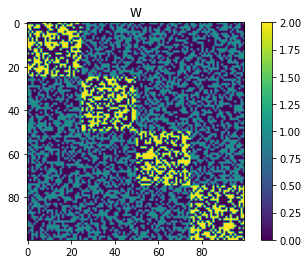

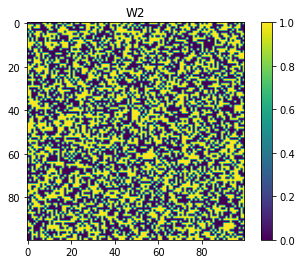

created 32 batches
created 8 batches


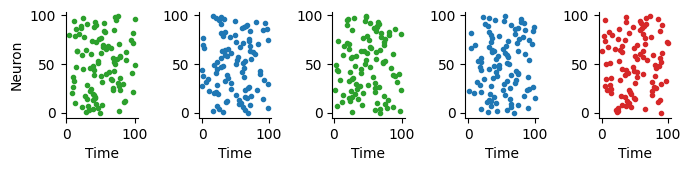

In [96]:
N=100
T=100
batch_size=100
nb_classes=4
W,W2 = get_Ws(N=N,nb_classes=nb_classes)

X_train,X_test,y_train, y_test, train_batch_ids,test_batch_ids =create_data(N=N,T=T,batch_size=batch_size,nb_classes=nb_classes,nb_samples=1000,alpha=1.5)
model = OneHiddenModel(in_channels=N,hidden_channels=100,out_channels=nb_classes,batch_size=batch_size)

In [ ]:
loss, acc = train(N=N,T=T,nb_classes=nb_classes,model=model,X_train=X_train,y_train=y_train,train_batch_ids=train_batch_ids,epochs=100,W=W,W2=W2,decay=.9,lr=1e-4,use_W=False,use_W2=False)

epoch 0: 
 loss: 1.268731713294983
train_acc: 0.3396874964237213
epoch 5: 
 loss: 1.060844898223877
train_acc: 0.4274999797344208
epoch 10: 
 loss: 0.9457330703735352
train_acc: 0.4962499141693115
epoch 15: 
 loss: 0.8127861022949219
train_acc: 0.5706250667572021
epoch 20: 
 loss: 0.6664505004882812
train_acc: 0.6381250023841858
epoch 25: 
 loss: 0.5979648232460022
train_acc: 0.671875
epoch 30: 
 loss: 0.5583304166793823
train_acc: 0.7034375071525574
epoch 35: 
 loss: 0.5079106688499451
train_acc: 0.7256247997283936
epoch 40: 
 loss: 0.4487249553203583
train_acc: 0.7381249070167542
epoch 45: 
 loss: 0.40821099281311035
train_acc: 0.745312511920929
epoch 50: 
 loss: 0.38819095492362976
train_acc: 0.7484375238418579
epoch 55: 
 loss: 0.37424397468566895
train_acc: 0.7518750429153442
epoch 60: 
 loss: 0.20202527940273285
train_acc: 0.9537498354911804
epoch 65: 
 loss: 0.07061540335416794
train_acc: 0.9931249022483826
epoch 70: 
 loss: 0.027305012568831444
train_acc: 0.9965624809265137
epo